In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
training = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Creating a concatenated dataset of both training and test data
training['train_test'] = 1 # indicates that it is training data
test['train_test'] = 0 # indicates that it is test data
test['Survived'] = np.NaN # filling in the column of Survived for test data as NaN because we don't know this 
all_data = pd.concat([training, test])
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

## Project Planning 

In [4]:
# understanding the nature of the data .info() .describe()
# histograms and boxplots 
# value counts 
# missing data (remove or impute missing data)
# correlation between the metrics 
# explore interesting themes:
    # do the wealthy survive
    # by location i.e. the cabin they were in 
    # age scatterplot with ticket price 
    # a young and wealthy variable?
    # total spent 
# feature engineering - important, one of the things that could improve accuracy
# preprocess data together or use a transformer?
    # use label for training and test
# scaling? 

# model baseline 
# model comparison with CV 

## Understanding the Nature of the Data 

For numeric data: 
- histograms to understand the correlation
- Correlation plots
- Pivot table to compare the survival rate across numeric variables

For categorical data: 
- made bar charts to understand the balance of classes
- made pivot tables to understand relationship wtih survival 

In [5]:
training.info() # allows us to look at our data types and null counts of each 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


We see that age and cabin both have a significant amount of null counts, so we need to think about how to manage that. We als osee that embarked has 2 null values. Next we can take a look at the numeric data

In [6]:
training.describe() # describe function allows us to better understand the numeric data (i.e. mean, std, central tendencies)

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  train_test  
count  891.000000  891.000000       891.0  
mean     0.381594   32.204208         1.0  
std      0.806057   49.693429         0.0  
min      0.000000    0.000000         1.0  
25%      0.000000    7.910400         1.0  
50%      0.000000   14.454200         1.0  
75%      0.000000   31.000000         1.0  
max      6.000000  512.329200         1.0

In [7]:
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

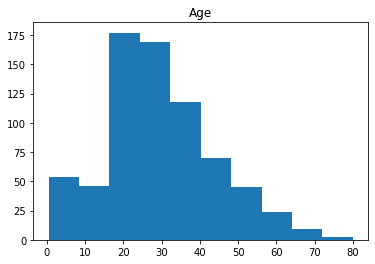

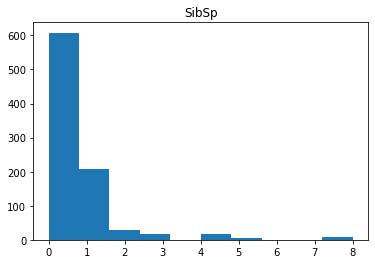

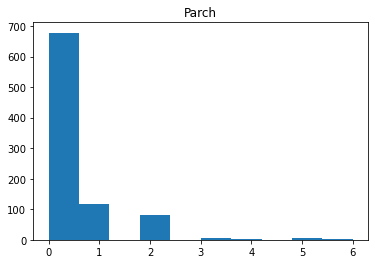

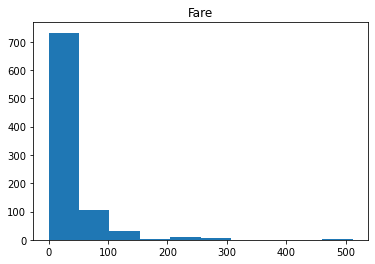

In [8]:
# we want to look at the numeric and categorical values seperately
df_num = training[['Age', 'SibSp', 'Parch', 'Fare']] # we want to understand these with histograms
df_cat = training[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']] # we want to understand these with value counts

# histograms for the numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

We see that age follows a fairly normal distribution, but the other three do not. We might want to normalize the fare variable because we see such a spike at a low price. 

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

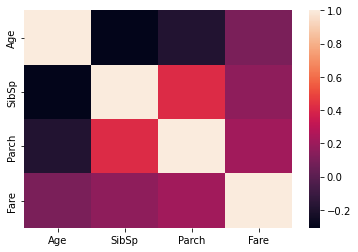

In [9]:
print(df_num.corr())
sns.heatmap(df_num.corr())

From the heatmap we can see that SibSp and Parch are correlated, but something like Age and SibSp are negatively correlated. This is important to look at especially if we are doing regression because we don't want multicollinearity in our model. (Though this project is a classification problem) Next we want to compare the survival rate across Age, SibSp, Parch and Fare - i.e. the numeric variables. 

In [10]:
pd.pivot_table(training, index = "Survived", values = ["Age", "SibSp", "Parch", "Fare"])

Age       Fare     Parch     SibSp
Survived                                          
0         30.626179  22.117887  0.329690  0.553734
1         28.343690  48.395408  0.464912  0.473684

We see that the average age of those who survived and didn't the average fare paid for those who survived and didn't etc. Notes down the significant differences i.e. it seems that the average fare for those that survived is significantly higher than the average fare price for those who didn't We also see that the average number of parents/children for those that survived is larger, so perhaps families that had children were given higher priority? Next we want to look at the categorical variables

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


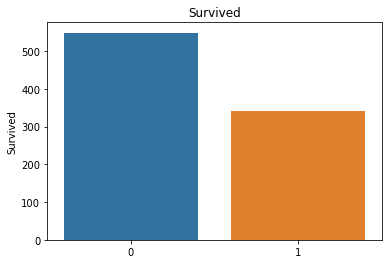

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


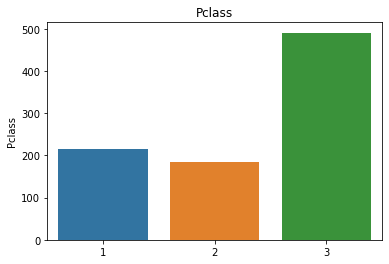

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


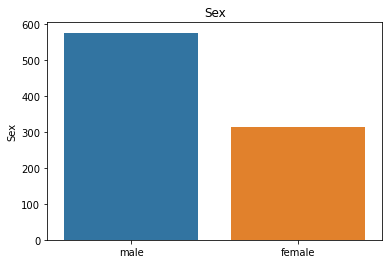

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


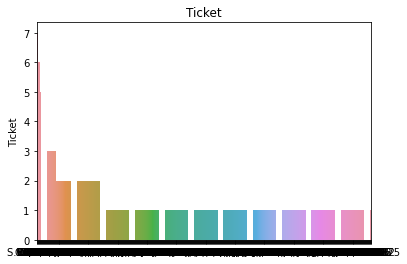

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


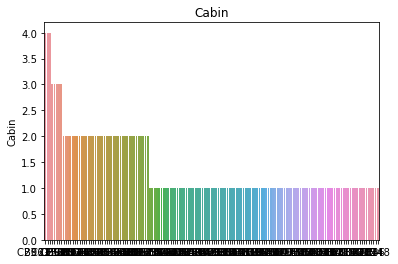

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


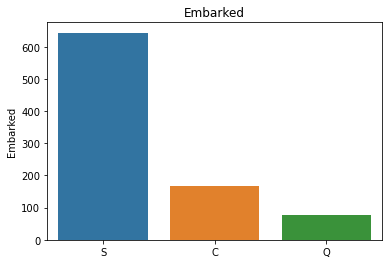

In [11]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()


1st Plot: survival rate i.e. how many people surived and how many didn't
2nd Plot: how many people were in each class (1 is 1st class, 3 is 3rd class)
3rd: how many males and females
4th: unintelligeble 
5th: unintelligible 
6th: how many people embarked from where
Since 4 (ticket number) and 5 (cabin number) are unintelligeble, we want to think about doing some feature engineering on them. Next we want to compare the survival of each of these categorical variables (just like with the numerical ones) except the ones that are unintelligeble - we will work on them in the feature engineering section. 

In [12]:
print(pd.pivot_table(training, index = "Survived", columns = "Pclass", values = "Ticket", aggfunc = "count"))
print(pd.pivot_table(training, index = "Survived", columns = "Sex", values = "Ticket", aggfunc = "count"))
print(pd.pivot_table(training, index = "Survived", columns = "Embarked", values = "Ticket", aggfunc = "count"))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Sex       female  male
Survived              
0             81   468
1            233   109
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


## Feature Engineering

Consider simplifying tickets and cabins because there will just be too many columns if we include them into our model 
1. Cabin 
2. Tickets - do different ticket types impact survival rates 
3. Does a person's title relate to survival rates 


### Cabin

We want to first look at simplifying cabins - we can consider  splitting cabins - we want to try andsimplify cabins into categories with less columns, so we will look at the letter of the cabin and the purchase of tickets across multiple cabins 

In [13]:
# Potential splits:
# cabin letter cabin_adv
# purchase of tickets across multiple cabins cabin_multiple
# First we look at cabin_multiple 
# i.e. we are seeing if people had multiple cabins 
df_cat.Cabin
training["cabin_multiple"] = training.Cabin.apply(lambda x : 0 if pd.isna(x) else len(x.split(" "))) # split on spaces and also adding the cabin_multiple variable to our dataset
training['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

We see that the vast majority of people did not have multiple cabins (0 = 687)

In [14]:
pd.pivot_table(training, index = "Survived", columns = "cabin_multiple", values = "Ticket", aggfunc = "count")

cabin_multiple      0      1    2    3    4
Survived                                   
0               481.0   58.0  7.0  3.0  NaN
1               206.0  122.0  9.0  3.0  2.0

In [15]:
# next we can look at the cabin letters
# we look at this because we would expect that cabins with the same letters will be on the same floor and area
# may make escape easier or harder 
training["cabin_adv"] = training.Cabin.apply(lambda x: str(x)[0]) # adding the cabin_adv variable to our training set
print(training.cabin_adv.value_counts())
pd.pivot_table(training, index="Survived", columns="cabin_adv", values="Ticket",aggfunc = "count")

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv    A     B     C     D     E    F    G    T      n
Survived                                                    
0          8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0  481.0
1          7.0  35.0  35.0  25.0  24.0  8.0  2.0  NaN  206.0

We can see that generally, people who had cabins tended to survive more than people without, so it is likely we can use this cabin_adv variable in our model. (i.e. we can use the letter of the cabin as a categorical variable in our model). It also takes it from us having 50 to 100 unique cabins to having just a few. 

In [20]:
# next we want to understand ticket values better 
# numeric vs non-numeric 
# each ticket number was unique, but some had letters and some didn't 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)

In [21]:
training['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [23]:
# let us view all rows in the dataframe through scrolling (for convenience)
pd.set_option("max_rows", None)
training['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: ticket_letters, dtype: int64

Probably won't include the specific ticket letters as something that is significant in the analysis - might be worth it to do if we want to do a deeper analysis, but there aren't enough unique ones to make it seem that important. 

In [25]:
# difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(training,index='Survived', columns='numeric_ticket',values='Ticket', aggfunc='count')

numeric_ticket    0    1
Survived                
0               142  407
1                88  254

We want to see if the difference in numeric vs non-numeric tickets had any impact on the survival rate. It looks like the ratios are fairly similar (142/407 and 88/254) - no significant difference. 

In [26]:
# we take a look at the survival rate with different ticket types (letters) 
pd.pivot_table(training, index='Survived', columns='ticket_letters',values='Ticket',aggfunc='count')

ticket_letters      0   a4    a5   as    c    ca  casoton   fa   fc  fcc  ...  \
Survived                                                                  ...   
0               410.0  7.0  19.0  1.0  3.0  27.0      1.0  1.0  1.0  1.0  ...   
1               255.0  NaN   2.0  NaN  2.0  14.0      NaN  NaN  NaN  4.0  ...   

ticket_letters  soc  sop  sopp  sotono2  sotonoq   sp  stono2  swpp   wc  wep  
Survived                                                                       
0               5.0  1.0   3.0      2.0     13.0  1.0    10.0   NaN  9.0  2.0  
1               1.0  NaN   NaN      NaN      2.0  NaN     8.0   2.0  1.0  1.0  

[2 rows x 29 columns]

Nothing too relevant with the ticket letters here either. 

In [27]:
# Feature engineering on a person's title (mr, ms, misses etc.)
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [28]:
training['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

We look at these because we want to see whether or not some of these have any effects on the survival rate - is someone who is royalty more likely to survive? Gives us more insight into the people rather than just have a male and female category. We see here that there aren't too many different surnames. To improve this, it might be better if we tried to group some of the people togeter, eg. Doctor, Rev, Mlle can be grouped together as working class people, or something along those lines. 


## Data Preprocessing for Model 


After exploring the data, we will move on to data preprocessing.  
  
1. Drop null values from Embarked (only 2)  
2. Include only relevant variables   
variables: Pclass, Sex, Age, Sibsp, Parch, Fare, Embarked, cabin_adv, cabin_multiple, numeric_ticket, name_title 
  
3. Do categorical transforms on all the data. Usually we would use a transformer, but with this approach we can ensure our training and test data have the same columns. We also may be able to infer something about the shape of the test data through this method. I will stress, this is generally not recommended outside of a competition - usually you will use one hot encoder.Here, we use pandas getdummies(). This means that when you have multiple categorical variables (eg. cabin has 7 different things), in order for the model to use that, for each of those individual cabins, you need one column and the column has a 0 if they weren't in that cabin and a 1 if they were in that cabin 

4. Impute data with mean for fare and age - also try using the median 
5. Normalized fare using logarithm to give more semblance of a normal distribution 
6. Scaled data 0-1 with standard scalar

(889,)

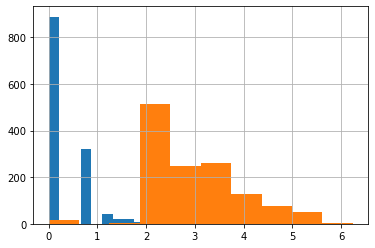

In [33]:
# create all categorical variables that we did above for both training and test sets - notice here that we are using all the data, so we ensure that the training and test sets both have the same column names 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/', '').lower() if len(x.split(' ')[:-1]) > 0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

# impute nulls for continuous data 
all_data.Age = all_data.Age.fillna(training.Age.mean())
all_data.Fare = all_data.Fare.fillna(training.Fare.mean())
# in theory we should have used the median for Fare because it is not normally distributed

# drop null 'embarked' rows. Only two instances of this in training and 0 in test 
all_data.dropna(subset = ['Embarked'], inplace = True)

# trying to normalize a couple variables 
# tried log norm of sibsp (normalize siblings variable) - didn't use this
all_data['norm_sibsp'] = np.log(all_data.SibSp + 1)
all_data['norm_sibsp'].hist() 

# log norm of fare - used this
all_data['norm_fare'] = np.log(all_data.Fare + 1)
all_data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

# created dummy variables from categories - can also use OneHotEncoder
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title', 'train_test']])

# Split to train test set again 
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis = 1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis = 1)

y_train = all_data[all_data.train_test == 1].Survived
y_train.shape 

After normalizing the Fare, we get a shape that is closer to Normal distribution here. Note this is the historgram of hte Fare variable after normalizing (the orange bars)

In [34]:
# Scale the data 
from sklearn.preprocessing import StandardScaler 
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']] = scale.fit_transform(all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']])
all_dummies_scaled 

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis=1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis=1)

y_train = all_data[all_data.train_test==1].Survived

## Model Building

Here we want to try a bunch of different models and experiment with how they do. We want to see how various models perform with some default parameters. Tried the following models with 5 fold cross validation to get a baseline. With a validation set basleine, we can see how much tuning improves each of these models. But note that just because a model has a high baseline on a validation set doesn't mean that it will do well on the eventual test set. &nbsp;

The models tried are: 
- Naive Bayes 
- Logistic Regression 
- Decision Tree 
- KNN 
- Random Forest 
- Support Vector Classifier 
- Xtreme Gradient Boosting 
- Soft Voting Classifier 

&nbsp;
We use cross validation - this takes some of the samples from our training set and splits them off, and it randomly samples from our training data, we run a model on some of that training data, and then it predicts. This way we validate the model on data that is held out and that should give us a better estimation of how it will perform in the real world. First we will train on the above models with no parameter tuning just to see how they perform. 

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression 
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 

In [38]:
# Usually we can use Naive Bayes as a baseline for classification- simple model and we always expect other models to do better.
# The general way is to just import the models from sklearn, create an instance of it and then fit it to the data. 
gnb = GaussianNB()
cv = cross_val_score(gnb, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
0.7221735542436362


In [39]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.82022472 0.80898876 0.80337079 0.82022472 0.85310734]
0.8211832666793626


In [40]:
# logistic regression on the scaled data 
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train_scaled, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.82022472 0.80898876 0.80337079 0.82022472 0.85310734]
0.8211832666793626


In [41]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.74719101 0.74157303 0.80898876 0.75842697 0.82485876]
0.776207706468609


In [42]:
# Decision tree on the scaled data 
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.74719101 0.74157303 0.80898876 0.75280899 0.81920904]
0.7739541674601662


In [43]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.76966292 0.80898876 0.80337079 0.81460674 0.83615819]
0.8065574811147084


In [44]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.79775281 0.79213483 0.83146067 0.80337079 0.85310734]
0.8155652891512728


In [45]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.82022472 0.78651685 0.85393258 0.73033708 0.84180791]
0.8065638291119152


In [46]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.81460674 0.78651685 0.85393258 0.73033708 0.84180791]
0.8054402336062972


In [47]:
svc = SVC(probability = True)
cv = cross_val_score(svc, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.84831461 0.82022472 0.8258427  0.80337079 0.86440678]
0.8324319177299563


In [50]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 1)
cv = cross_val_score(xgb, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of lab

[16:30:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Voting classifier - takes all the inputs and averages the results. For a "hard" voting classifier, each classifier gets one vote, a "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers. &nbsp;

A "soft" voting classifier averages the confidence of each of the models. If the average confidence is > 50% (that is it is a 1), it will be counted as such. 

In [52]:
from sklearn.ensemble import VotingClassifier 
voting_clf = VotingClassifier(estimators = [('lr', lr), ('knn', knn), ('rf', rf), ('gnb', gnb), ('svc', svc), ('xgb', xgb)], voting = 'soft')

In [53]:
cv = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.83146067 0.81460674 0.83146067 0.80337079 0.85875706]
0.8279311877102774


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [55]:
voting_clf.fit(X_train_scaled, y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data = basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

[19:34:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## Model Tuning

After getting the baselines, lets see if we can improve on the individual model results. We will try using grid search to tune the models. We can also use Randomized search for the Random Forest and XG Boosted model to simplify testing time. 

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [57]:
# Define a simple performance reporting function 
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [84]:
# Grid search allows us to put in a bunch of parameters and try them all. It spits out a bunch of parameters that return the
# best results. 
lr = LogisticRegression()
param_grid = {'max iter' : [2000], 
              'penalty' : ['l1', 'l2'], 
              'C' : np.logspace(-4,4,20), 
              'solver': ['liblinear']}



In [85]:
clf_lr = GridSearchCV(lr, param_grid=param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled, y_train)
clf_performance(best_clf_lr, 'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


ValueError: Invalid parameter max iter for estimator LogisticRegression(C=0.0001). Check the list of available parameters with `estimator.get_params().keys()`.

In [68]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9], 
              'weights' : ['uniform', 'distance'], 
              'algorithm' : ['auto', 'ball_tree', 'kd_tree'], 
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid=param_grid, cv=5, verbose=True, n_jobs= -1)
best_clf_knn = clf_knn.fit(X_train_scaled, y_train)
clf_performance(best_clf_knn, 'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8301720307243065
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


In [70]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel' : ['rbf'], 
                                  'gamma' : [.1, .5, 1, 2, 5, 10], 
                                  'C': [.1, 1, 10, 100, 1000] }, 
                                 {'kernel' : ['linear'], 
                                  'C': [.1 , 1, 10, 100, 1000]}, 
                                 {'kernel': ['poly'], 'degree':[2,3,4,5], 
                                  'C':[.1,1,10,100,1000]}]
clf_svc = GridSearchCV(svc, param_grid=param_grid, cv=5, verbose = True, n_jobs=-1)
best_clf_svc = clf_svc.fit(X_train_scaled, y_train)
clf_performance(best_clf_svc, 'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
SVC
Best Score: 0.8324319177299563
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


For RandomForest (and also XGBoost later), there are technically an infinite number of parameters that we can try. It would take a very long time since hte total feature space is so large. Thus, we use a randomized search to narrow down the parameters of the model. We then take the best model from this and do a more granular search. A randomized search just means it doesn't try all of the params in the param_grid, it randomly samples from the options in the param_grid and then returns the best results from that. Then after getting the best results, we can tune it further and try to get something that might perform a little bit better. 

In [71]:
rf = RandomForestClassifier(random_state = 1)
param_grid = {'n_estimators': [100,500,1000], 
              'bootstrap': [True,False], 
              'max_depth': [3,5,10,20,50,75,100,None], 
              'max_features': ['auto', 'sqrt'], 
              'min_samples_leaf': [1,2,4,10], 
              'min_samples_split': [2,5,10]}

clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled, y_train)
clf_performance(best_clf_rf_rnd, 'Random Forest')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random Forest
Best Score: 0.8335301212467467
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [72]:
rf = RandomForestClassifier(random_state = 1)
param_grid = {'n_estimators': [400,450,500,550], 
              'criterion':['gini', 'entropy'], 
              'bootstrap': [True], 'max_depth': [15,20,25], 
              'max_features': ['auto', 'sqrt', 10], 
              'min_samples_leaf': [2,3], 
              'min_samples_split' : [2,3]}

clf_rf = GridSearchCV(rf, param_grid = param_grid, cv=5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled, y_train)
clf_performance(best_clf_rf, 'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Random Forest
Best Score: 0.8358027042468101
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


<AxesSubplot:>

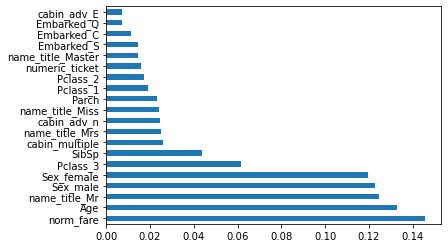

In [73]:
# taking a quick look at feature importances:
# i.e. which features have the greatest impact in predicting whether someone survives or not 
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled, y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [75]:
xgb = XGBClassifier(random_state = 1)

param_grid = {'n_estimators': [20,50,100,250,500,1000], 
              'colsample_bytree' : [0.2,0.5,0.7,0.8,1], 
              'max_depth': [2,5,10,15,20,25,None], 
              'reg_alpha': [0,0.5,1], 
              'reg_lambda': [1, 1.5,2], 
              'subsample': [0.5,0.6,0.7,0.8,0.9], 
              'learning_rate':[.01,0.1,0.2,0.3,0.5,0.7,0.9],
              'gamma':[0,.01,0.1,1,10,100], 
              'min_child_weight' : [0,.01,0.1,1,10,100], 
              'sampling_method' : ['uniform', 'gradient_based']}

# Grid Search
# clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
# best_clf_xgb = clf_xgb.fit(X_train_scaled, y_train)
# clf_performance(best_clf_xgb, 'XGB')

Fitting 5 folds for each of 4762800 candidates, totalling 23814000 fits


KeyboardInterrupt: 

In [77]:
# Random Forest 
clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter=1000, cv=5, verbose=True, n_jobs = -1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train_scaled, y_train)
clf_performance(best_clf_xgb_rnd, 'XGB')

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[12:30:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
Best Score: 0.8504030978226369
Best Parameters: {'subsample': 0.8, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 0.1, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.78739923 0.84029709        nan 0.61754586        nan        nan
        nan        nan        nan 0.84138259 0.83354917        nan
 0.61754586 0.61754586        nan        nan 0.84253158 0.81665714
        nan        nan        nan        nan        nan 0.83014029
 0.81891068 0.61754586        nan        nan        nan 0.82677585
 0.61754586        nan        nan        nan 0.83131467        nan
        nan 0.74919698        nan        nan 0.61754586 0.79753698
 0.78627563 0.78627563 0.81439726 0.8380372  0.8155399         nan
 0.65144417        nan        nan        nan 0.83466006 0.78627563
        nan 0.61754586        nan        nan 0.81778709        nan
 0.61754586        nan        nan 0.83463467        nan        nan
 0.82004063 0.81328636        nan 0.79867962 0.83467276 0.8053958
        nan        nan 0.79979052 0.8256586  0.61754586

In [78]:
xgb = XGBClassifier(random_state = 1)

param_grid = {'n_estimators' : [450,500,550], 
              'colsample_bytree' : [0.75,0.8,0.85], 
              'max_depth': [None], 
              'reg_alpha': [1], 
              'reg_lambda' : [2,5,10], 
              'subsample' : [0.55,0.6,0.65], 
              'learning_rate': [0.5], 
              'gamma':[0.5, 1,2], 
              'min_child_weight': [0.01], 
              'sampling_method': ['uniform']}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled, y_train)
clf_performance(best_clf_xgb, 'XGB')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
Best Score: 0.8526502888338727
Best Parameters: {'colsample_bytree': 0.85, 'gamma': 1, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 5, 'sampling_method': 'uniform', 'subsample': 0.65}


In [79]:
y_hat_xgb = best_clf_xgb.best_estimator_.predict(X_test_scaled)
xgb_submission = {'PassengerId' : test.PassengerId, 'Survived' : y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission.csv', index = False)

## Model additional ensemble approaches 

1. Experimented with a hard voting classifier of three estimators (KNN, SVM, RF)
2. Experimented with a soft voting classifier of three estimators (KNN, SVM, RF)
3. Experimented with a soft voting on all estimators performing better than 80% except XGB (KNN, RF, LR, SVC)
4. Experimented with soft voting on all estimators including XGB (KNN, SVM, RF, LR, XGB) &nbsp;

Here we are just taking all the best estimators and making a bunch of voting classifiers 

In [86]:
# best_lr = best_clf_lr.best_estimator_ 
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

In [89]:
voting_clf_hard = VotingClassifier(estimators = [('knn', best_knn), ('rf', best_rf), ('svc', best_svc)], voting = 'hard')
voting_clf_soft = VotingClassifier(estimators = [('knn', best_knn), ('rf', best_rf), ('svc', best_svc)], voting = 'soft')
voting_clf_xgb = VotingClassifier(estimators = [('knn', best_knn), ('rf', best_rf), ('svc', best_svc), ('xgb', best_xgb)], voting = 'soft')

In [91]:
print('voting_clf_hard :', cross_val_score(voting_clf_hard, X_train, y_train, cv=5))
print('voting_clf_hard mean :', cross_val_score(voting_clf_hard, X_train, y_train, cv=5).mean())

voting_clf_hard : [0.79213483 0.81460674 0.8258427  0.80898876 0.83615819]
voting_clf_hard mean : 0.8155462451596522


In [92]:
print('voting_clf_soft :', cross_val_score(voting_clf_soft, X_train, y_train, cv=5))
print('voting_clf_soft mean :', cross_val_score(voting_clf_soft, X_train, y_train, cv=5).mean())

voting_clf_soft : [0.78089888 0.83146067 0.82022472 0.81460674 0.86440678]
voting_clf_soft mean : 0.8234431536850124


In [93]:
print('voting_clf_xgb :', cross_val_score(voting_clf_xgb, X_train, y_train, cv=5))
print('voting_clf_xgb mean :', cross_val_score(voting_clf_xgb, X_train, y_train, cv=5).mean())

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
voting_clf_xgb : [0.83707865 0.8258427  0.84269663 0.82022472 0.85310734]


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
voting_clf_xgb mean : 0.8346600647495717


We want to see whether the weights of the models have any impact on the output here. Do a grid search and experiment with different votes in the soft voting classifier. So that means we add additional weightings to one or two of the models so that it counts for more in the analysis. 

In [94]:
params = {'weights': [[1,1,1], [1,2,1], [1,1,2], [2,1,1], [2,2,1], [1,2,2], [2,1,2]]}

vote_weight = GridSearchCV(voting_clf_soft, param_grid=params, cv = 5, verbose=True, n_jobs= -1)
best_clf_weight = vote_weight.fit(X_train_scaled, y_train)
clf_performance(best_clf_weight, 'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
VC Weights
Best Score: 0.8324446137243701
Best Parameters: {'weights': [1, 1, 1]}


Making predictions. We go through and fit all the data. For each of the classifiers we made we need to fit it to the data, and then after we fit it we can predict the results we got. 

In [95]:
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_xgb.fit(X_train_scaled, y_train)

best_rf.fit(X_train_scaled, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled)
y_hat_rf = best_rf.predict(X_test_scaled)
y_hat_vc_soft = voting_clf_soft.predict(X_test_scaled)
y_hat_vc_xgb = voting_clf_xgb.predict(X_test_scaled)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:02:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [96]:
# Convert the outputs to a data frame
final_data_1 = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission_1 = pd.DataFrame(data=final_data_1)

final_data_2 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_xgb}
submission_4 = pd.DataFrame(data=final_data_4)

In [97]:
# submission files
submission_1.to_csv('submission_rf.csv', index = False)
submission_2.to_csv('submission_vc_hard.csv', index = False)
submission_3.to_csv('submission_vc_soft.csv', index = False)
submission_4.to_csv('submission_vc_xgb.csv', index = False)